In [1]:
from epi_model import *

In [2]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx
import matplotlib.pyplot as pyplot

In [3]:
from generate_SEIRS import *

# top level parameters

In [4]:
T = 100 # time of the simulations
INIT_EXPOSED_PCT = 20/330 # initially exposed... this is modified later anyways now...

## Specifying contact networks

I'm doing it myself in this one

In [5]:
tnet = temporalNetwork.load('high school').range(1,2)

0.01, 0.02, 0.09, 1.00


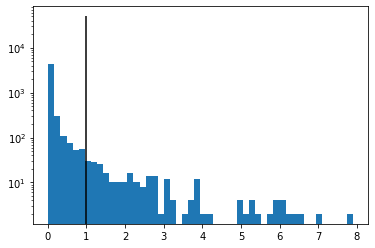

In [6]:
# ================================================
# ======   Reformulate temporal network    =======
# ================================================

counts = Counter([(i,j) for _,i,j in tnet.edgelist])

max(sorted(tnet.G.nodes)) 

#nodes = sorted(tnet.nodes)
n2id = {n:i for i,n in enumerate(tnet.node_ids)}
#nodes = sorted(tnet.nodes)
#n2id2 = {n:i for i,n in enumerate(sim.tnet.nodes)}

wts = np.array([c/(30*60/20) for (i,j),c in counts.items()]) # 30 minutes ~= 1X transmissibility

G = nx.Graph()
G.add_weighted_edges_from( [(n2id[i], n2id[j], wts[ei]) for ei,((i,j),c) in enumerate(counts.items())] )

plt.hist( wts, bins=50, log=True );
plt.vlines(1,0,50000);
print( ", ".join([f"{x:0.2f}" for x in [np.quantile(wts,0.25), np.quantile(wts,0.50), np.quantile(wts,0.75), np.quantile(wts,0.95)]]) )

G_baseline = G

In [7]:
Nn = len(G_baseline.nodes)

Baseline:
Degree: mean = 16.60, std = 8.10, 95% CI = (4.00, 34.27)
        coeff var = 0.49
Assortativity:    0.12
Clustering coeff: 0.42



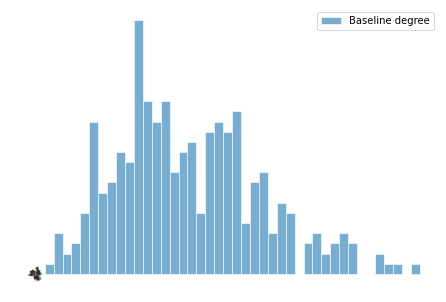

In [8]:
nx.draw(G, node_size=0, edge_color=(0.2,0.2,0.2,0.05))
#plt.xlim()

network_info(G_baseline, "Baseline", plot=True)

# parameters

310
Individual R0:  mean = 2.51, std = 0.49, 95% CI = (1.64, 3.43)



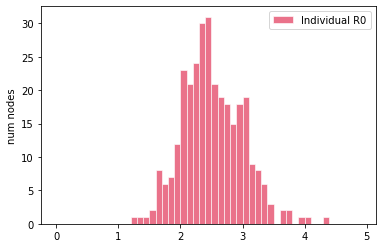

latent period:  mean = 2.15, std = 0.99, 95% CI = (0.75, 4.31)

pre-symptomatic period:  mean = 3.03, std = 1.81, 95% CI = (0.54, 7.00)

total incubation period:  mean = 5.18, std = 2.16, 95% CI = (1.97, 9.88)



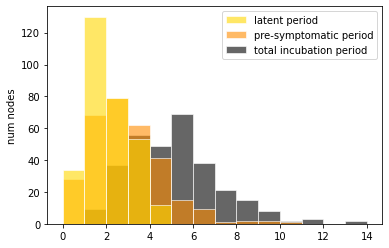

pre-symptomatic period:  mean = 2.15, std = 0.99, 95% CI = (0.75, 4.31)

(a)symptomatic period:  mean = 4.21, std = 1.64, 95% CI = (1.77, 7.98)

total infectious period:  mean = 6.36, std = 1.92, 95% CI = (3.34, 10.75)



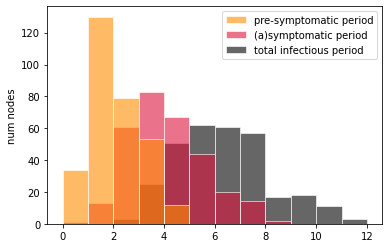

In [9]:
base_args = generate_params(G_baseline)

## Initializing the model

In [10]:
model = ExtSEIRSNetworkModel(**base_args)

# run some simulations

In [11]:
bb = networkx.adj_matrix(model.G).toarray()

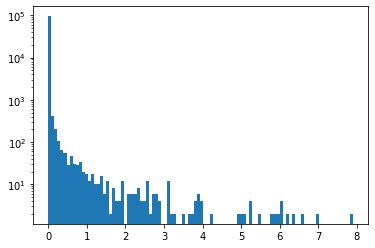

In [12]:
plt.hist(bb.flatten(), bins=100, log=True);

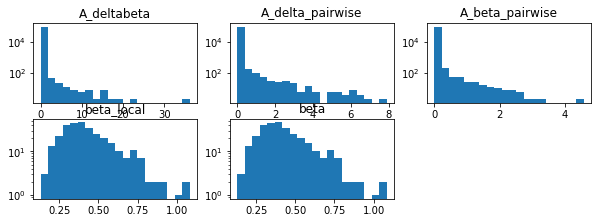

In [13]:
# parameters sanity check
names = "A_deltabeta,A_delta_pairwise,A_beta_pairwise,beta_local,beta".split(",")
sq = np.ceil(np.sqrt(len(names)))
plt.figure(figsize=(10,5))

for xi,x in enumerate(names):
    plt.subplot(sq,sq,xi+1)
    attr = getattr(model, x)
    if type(attr) == scipy.sparse.csr_matrix:
        attr = attr.toarray()
    plt.hist(attr.flatten(), bins=20, log=True);
    plt.title(x)
plt.show()

In [14]:
p = dict(params.covid_estimate)
sim = simulations.SEIR_daily(tnet, p)

In [15]:
n2id = {n:i for i,n in enumerate(tnet.nodes)}

In [16]:
attrs_to_keep = [k for k in model.__dict__ if 'num' == k[:3]]
attrs_to_keep += ['tseries']

In [17]:
def friendHighDegRandTop3(sim, vaccinateN):
    return sampling.friendHighDegRandTopN(sim, vaccinateN, N=3)
def friendHighDegRandTop5(sim, vaccinateN):
    return sampling.friendHighDegRandTopN(sim, vaccinateN, N=5)

In [18]:
strats = [
    sampling.friendClose,
    sampling.friendHighDegClose,
    sampling.friendHighDeg,
    sampling.targeted,
    sampling.none,
    sampling.rand,
    #sampling.friendWeightedChain,
]

strats += 1*[
    sampling.friend,
    sampling.friendHighDegChain,
    friendHighDegRandTop3,
    friendHighDegRandTop5,
]

In [19]:
models = defaultdict(list)

In [20]:
N_PER = 200

In [21]:
from time import time
from frozendict import frozendict

In [22]:
from simulation_helper import *

In [35]:
import simulation_helper
from importlib import reload
reload(simulation_helper)
iter_args = simulation_helper.iter_args

In [36]:
# this is one way, but it's too many permutations.
# no way I actually need this many experiments...

argsets = iter_args({
    'strat': {x.__name__: x for x in strats},
    'R0_mean': [1, 2.5, 4],
    'VACCINATE_P': [0.05, 0.10, 0.20, 0.50],
    'INITIAL_INFECT': [5, 10, 20]
})

print(len(argsets))

360


In [37]:
argset1 = iter_args({
    'strat': {x.__name__: x for x in strats},
    'R0_mean': 2.5,
    'VACCINATE_P': [0.05, 0.10, 0.20, 0.50],
    'INITIAL_INFECT': 20
})
len(argset1)

argset2 = iter_args({
    'strat': {x.__name__: x for x in strats},
    'R0_mean': [1, 2.5, 4],
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': 20
})
len(argset2)

argset3 = iter_args({
    'strat': {x.__name__: x for x in strats},
    'R0_mean': 2.5,
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': [5, 10, 20]
})
len(argset3)

argsets = argset1 + argset2 + argset3
len(argsets)

100

In [38]:
N_iters = len(argsets) * N_PER
N_iters

20000

In [39]:
argsets[0]

(frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friend'}),
 {'INITIAL_INFECT': 20,
  'R0_mean': 2.5,
  'VACCINATE_P': 0.05,
  'strat': <function epi_model.sampling.friend(sim, vaccinateN=100)>})

In [40]:
for argseti, (sname, argset) in enumerate(argsets):
    locals().update(argset)
    
    #if (argseti+1)%int(len(argsets)/100) == 0:
    print(f'Doing {sname}. {argseti}/{len(argsets)}. {N_PER - len(models[sname])} to do.')
    first_it = True

    for i in range(N_PER - len(models[sname])):

        ns_to_remove = strat(sim, int(Nn*VACCINATE_P))
        ns_to_remove = [n2id[x] for x in ns_to_remove]

        ALPHA = [0.5 if i not in ns_to_remove else 0 for i in range(Nn)]

        args = dict(base_args)
        args['alpha'] = ALPHA
        #args['initI_asym'] = INITIAL_INFECT

        model = ExtSEIRSNetworkModel(**args)

        # reconstruct X myself
        ns_to_infect = sample( [i for i in range(Nn) if i not in ns_to_remove], INITIAL_INFECT )

        for i in range(Nn):
            if i in ns_to_infect:
                model.X[i] = model.I_sym

        # hard-code this to avoid ridiculousness
        model.A_deltabeta = model.A

        # sanity checks
        assert all( 0<=i<=Nn for i in ns_to_remove )
        assert all( 0<=i<=Nn for i in ns_to_infect )

        st = time()
        model.run(100,verbose=False)
        if first_it:
            t_iter = time()-st
            print(f'{t_iter:0.1f} seconds for first simulation. At that rate it\'ll take {N_iters*t_iter/3600:0.1f} hours.')
            first_it = False

        models[sname].append({
            k: getattr(model, k)
            for k in attrs_to_keep
        })

Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friend'}). 0/100. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friend'}). 1/100. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friend'}). 2/100. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5, 'strat': 'friend'}). 3/100. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friendClose'}). 4/100. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friendClose'}). 5/100. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friendClose'}). 6/100. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5, 'strat': 'friendClose'}). 7/100. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.0

In [41]:
nodes = tnet.nodes

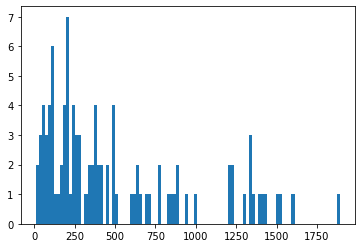

In [42]:
plt.hist(strat(sim,100), bins=100);

In [43]:
# sanity checks
who_got_infected = [x['infected_node'] for x in model.infectionsLog]

print(
    all( x in range(Nn) for x in strat(sim, 5) ),
    #all( n2id[ nodes[x] ] == x for x in strat(sim,100) ),
    tuple(sorted(sim.tnet.G.nodes)) == tuple(range(Nn)),
    all( x in range(Nn) for x in ns_to_remove ),
    tuple(sorted(tnet.G.edges)) == tuple(sorted(G.edges)), # this is crutial wtf...
    any(i in ns_to_remove for i in who_got_infected),
    len(who_got_infected), len(ns_to_infect), model.numS[:5], model.numS[-5:],
    all(i in ns_to_infect for i in who_got_infected),
)

False False True False False 7 10 [310. 300. 299. 299. 299.] [293. 293. 293. 293. 293.] False


In [50]:
for x in models.keys():
    print(x)

frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friend'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friend'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friend'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5, 'strat': 'friend'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friendClose'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friendClose'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friendClose'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5, 'strat': 'friendClose'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friendHighDeg'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friendHighDeg'})
frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P'

In [44]:
print([len(m) for m in models.values()])

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


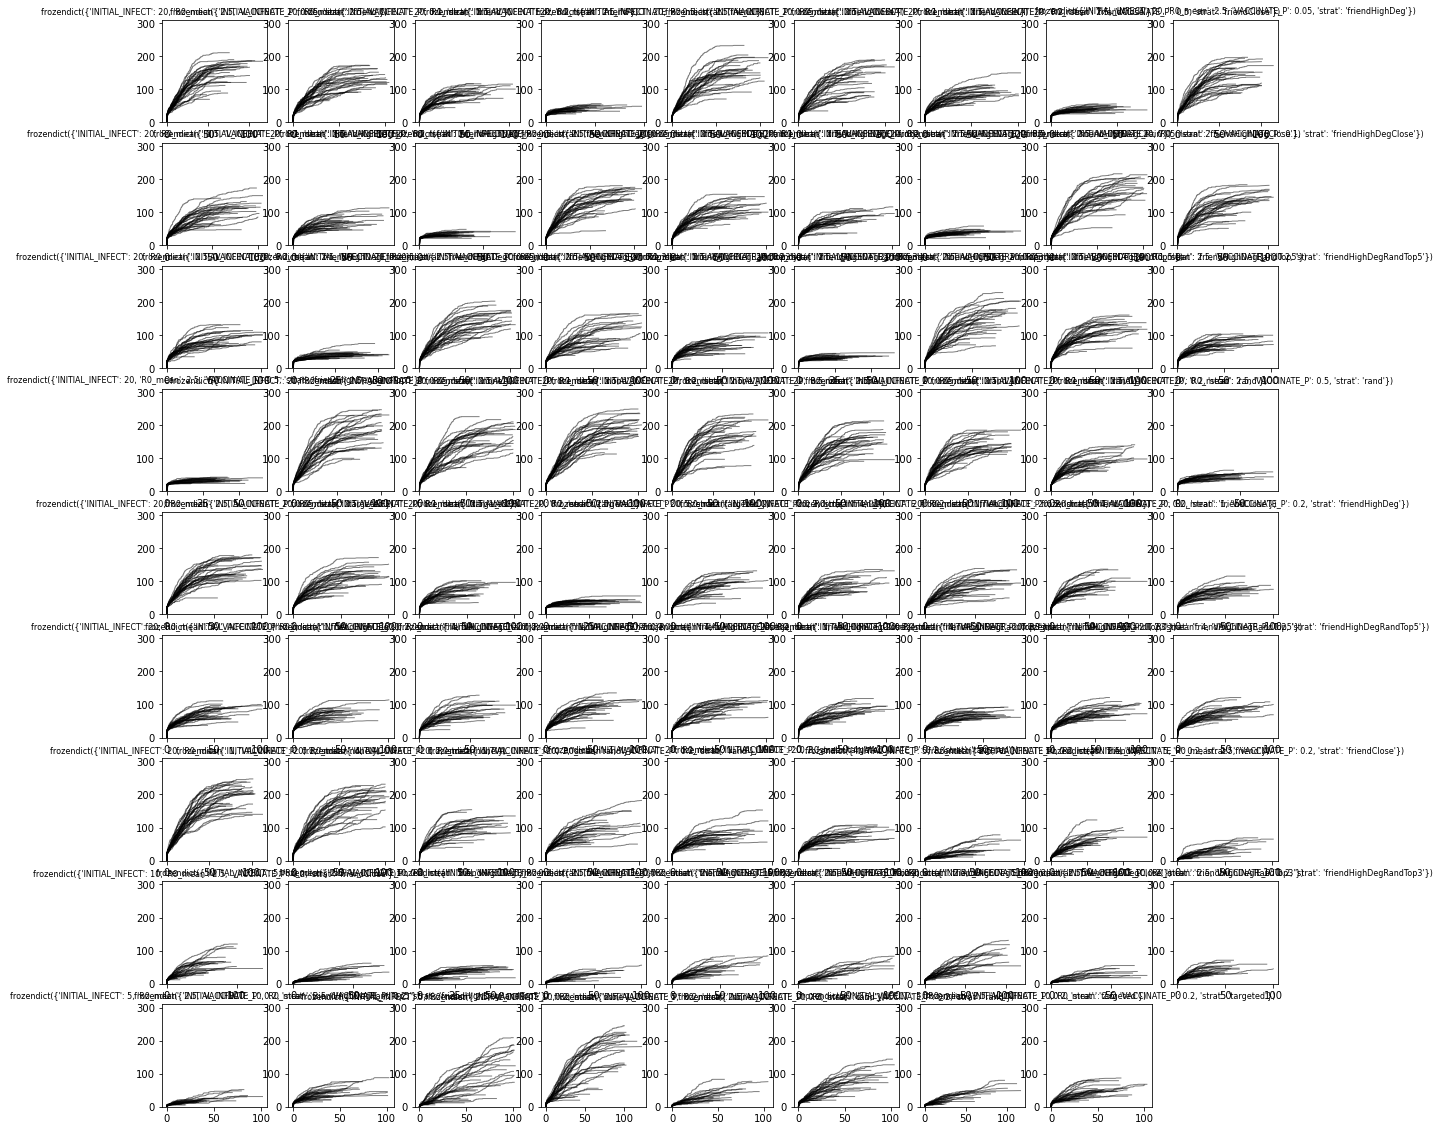

In [48]:
plt.figure(figsize=(20,20))

nsqrs = np.ceil( np.sqrt(len(models)) )

for ki,k in enumerate(models):
    plt.subplot(nsqrs, nsqrs, ki+1)
    for i in range( min(30,len(models[k])) ):
        m = models[k][i]

        plt.plot(m['tseries'], m['numNodes'] - m['numS'], label=i, linewidth=1, color='black', alpha=0.5)
    #plt.legend()
    plt.title(k, fontsize=8)
    plt.ylim(0,m['numNodes'])

In [46]:
import json

In [47]:
NAME = 'HS1_2'

with open(f'simulation_results/{NAME}.pickle', 'wb') as outf:
    pickle.dump(models, outf)

# bleh...
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'tolist'):
            return obj.tolist()
        if type(obj) == nx.classes.graph.Graph:
            return 'graph'
        return json.JSONEncoder.default(self, obj)
    
with open(f'simulation_results/{NAME}.args.json', 'w', encoding='utf8') as outf:
    json.dump(base_args, outf, cls=NumpyEncoder)